In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import os
import random

plt.style.use('ggplot')
batchSize = 32
imgHeight = 400
imgWidth = 400

2024-12-06 21:03:02.278360: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Image Data

In [2]:
#Load in the image target data for each class
def LoadImageClassData():
    classNames= ["bird", "boat", "bus", "cat", "cow"]
    allData = {}
    entries = os.scandir("Training")

    target = 5 # default is none of the classes
    #targets for bird is 0, boat is 1, bus is 2, cat is 3, and cow is 4
    for entry in entries:
        path = 'Training/' + entry.name
        with open(path, 'r') as f:
            #find appropriate target class and change target to the class target
            for x in range(len(classNames)):
                if entry.name.startswith(classNames[x]):
                    target = x
            data = f.read()
            for line in data.split('\n'):
                allLines = line.split()
                imgName = allLines[0]

                #only use the 2008 images
                if not imgName.startswith("2008"):
                    continue
                # if it's a yes, change the target to the class target
                if(int(allLines[1]) == 1):
                    allData[imgName] = target
                # if the image target already exists, continue
                elif imgName in allData.keys():
                    continue
                #otherwise the image is of None class
                else: 
                    allData[imgName] = 5

    #reform training data to be 2 lists, one of image names, the other of targets
    imageData = []
    targetData = []

    for x in allData.keys():
        imageData.append(x)
        targetData.append(allData[x])

    return (imageData,targetData)

allData = LoadImageClassData()

print(len(allData[0]), len(allData[1]))


4332 4332


In [3]:
#Loads in all the images from a specified image directory
def LoadImageData(imageDir, message):
    print("Reading in " + message + " images from disk, this will take approximately 30 seconds")
    entries = os.scandir(imageDir)
    count = 0
    imagesAsNumpyArrays = {} # key: imageName, value: image as an array
    for entry in entries:
        count+= 1
        path = imageDir + "/" + entry.name
        #Skip this file since it's not an image
        if(entry.name == ".DS_Store"):
          continue
        #Convert the compressed string to a 3D uint8 tensor
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        
        #put the image in a dictionary
        imagesAsNumpyArrays[entry.name.split(".")[0]] = img
    print("Finished reading in " +  message  + " images")
    return imagesAsNumpyArrays

images = LoadImageData("Images", "training")
print("training images length:",len(images))

Reading in training images from disk, this will take approximately 30 seconds
Finished reading in training images
training images length: 4340


In [4]:
#Split the specified data into specified number of folds
def GetKFoldValidationData(folds, allData):
    data = {}

    #combine data into one dictionary to keep the data and the target together
    for x in range(len(allData[0])):
        data[allData[0][x]] = allData[1][x]

    #shuffle the data
    l = list(data.items())
    random.shuffle(l)
    shuffledData = dict(l)

    #split it into folds parts
    kFolds = []
    foldLength = int(len(shuffledData) / folds)
    imgNames = []
    target = []

    shuffledDataList = list(shuffledData.items())
    # for each shuffled data, but it back into an image names part and a target part and split it into folds parts
    for x in range(1, len(shuffledDataList)):
        imgNames.append(shuffledDataList[x-1][0])
        target.append(shuffledDataList[x-1][1])
        #if have enough data, put it in Kfolds and empty the lists
        if x % foldLength == 0:
            #if it's the second to last fold, leave
            if(len(kFolds) == folds - 1):
                break
            kFolds.append((imgNames.copy(), target.copy()))
            imgNames = []
            target = []

    sdlen = len(shuffledDataList)
    #put the data into the lists if it didn't fit perfectly into the folds
    for x in range(sdlen % folds):
        index = sdlen - x-1
        imgNames.append(shuffledDataList[index][0])
        target.append(shuffledDataList[index][1])
    kFolds.append((imgNames.copy(), target.copy()))

    return kFolds

# CNN

In [5]:
#construct the cnn with the first fully connected layer having numNeurons neurons
def cnn(numNeurons):
    model = tf.keras.Sequential([
        #first convolution layer
        tf.keras.layers.Conv2D(32, (11,11), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=4),
        
        #second convolution layer
        tf.keras.layers.Conv2D(48, (5,5), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=4),

        #third convolution layer
        tf.keras.layers.Conv2D(192, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=4),

        #fourth convolution layer
        tf.keras.layers.Conv2D(192, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=4),

        tf.keras.layers.Flatten(),
        
        #fully connected layers
        tf.keras.layers.Dense(numNeurons, activation='relu'), #the layer where the weights come from
        tf.keras.layers.Dense(64, activation='relu'),

        #classification layer
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    return model

In [6]:
#to normalize the pixels
normalization_layer = tf.keras.layers.Rescaling(1./255)
#to resize the images
resizing_layer = tf.keras.layers.Resizing( 
    imgHeight,
    imgWidth, 
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    fill_mode='constant',
    fill_value=0.0,
    data_format=None,)

#get specified image names as actual images that are resized, normalized and might be augmented
def GetImagesAsArray(singClassImages, bigImageDict, target, canTransform):
    allImages = []
    newTarget = []
    index = -1
    #for each image name
    for image in singClassImages:
        index+=1
        
        #if the image does not exist for some reason
        if image not in bigImageDict.keys():
            continue
        #resize data to be 400 x 400 pixels
        resized = resizing_layer(bigImageDict[image])
        #normalize data
        norm = normalization_layer(resized)

        #each training image has a 5% change of being augmented
        if(canTransform and random.uniform(0,10) > 9.5):
            #based on the index, rotate, flip, or mirror the image
            if index % 3 == 0: 
                rotImg = tf.image.rot90(norm)
                allImages.append(rotImg)
                newTarget.append(target[index])
            elif index % 3 == 1:
                flippedImg = tf.image.flip_up_down(norm)
                allImages.append(flippedImg)
                newTarget.append(target[index])
            else:
                mirrorImg = tf.image.flip_left_right(norm)
                allImages.append(mirrorImg)
                newTarget.append(target[index])
        #add the original image to the arrays
        allImages.append(norm)
        newTarget.append(target[index])
        
    print("len of images:", len(allImages))
    return (np.array(allImages),newTarget)

# Linear Regression

In [7]:
#returns sign of a number
def sign(num):
  if num < 0:
    return -1
  else:
    return 1

In [8]:
#initializes the weights with linear regression using a specified training data and target data
def initializeWeights(trainingData, target):
  bigX = np.array(trainingData)
  bigY = np.array(target)

  #the pseudo inverse
  pinv = np.linalg.pinv(bigX)
  weights = np.dot(pinv, bigY)

  return weights

In [9]:
#calculate linear regression using specified training data, target data and max iterations
def linRegression(trainingData, target, maxIterations):
  weights = initializeWeights(trainingData, target)

  #for each iteration
  for t in range(0,maxIterations):
    #calculate the pseudo inverse and get the new weights
    pseduoInv = np.linalg.pinv(trainingData)
    newWeights = np.dot(pseduoInv, target)

    oldErr = linError(trainingData, target, weights)
    newErr = linError(trainingData, target, newWeights)
    #if the newWeights have less error, use those
    if(newErr == 0):
      return newWeights
    if(newErr < oldErr):
      weights = newWeights
  return weights

In [10]:
#calculate accuracy for linear regression using specified testing data, target data, and weights
def linAccuracy(testingData, target, weights):
  correct = 0
  #the lowest length, which is either the length of the testing data or the target data
  #used so there's no index out of range error
  lowest = 0
  if(len(target) > len(testingData)):
    lowest = len(testingData)
  else:
    lowest = len(target)
  #calculate the accuracy
  for n in range(lowest):
    weightedSum = np.dot(np.transpose(weights), testingData[n])
    if sign(weightedSum) == target[n]:
      correct +=1

  return correct / lowest

In [11]:
#calculate mean squared error for linear regression using specified training data, target data and weights
def linError(trainingData, target, weights):
  err = 0
  for n in range(len(trainingData)):
    wSum = np.dot(np.transpose(weights), trainingData[n])
    sub = np.subtract(wSum, target[n])
    err +=  np.multiply(sub, sub)
  return (1/len(trainingData)) * err

# Put Everything Together

In [12]:
#Reclassifies target data to be [-1,1] based on class x
def ReclassifyingTargetData(x, target):
    newTarget = []
    for i in range(len(target)):
        if target[i] != x:
            newTarget.append(-1)
        else:
            newTarget.append(1)
    return newTarget

In [13]:
#Creates the CNN to linear regression model and returns the accuracies for each fold for each class
def GetCNNModels():
    #split the data
    kFoldData = GetKFoldValidationData(5, allData)
    accuracies = []
    #for each fold
    for x in range(len(kFoldData)):
        #combine all training Data
        trainingDataImages = []
        trainingDataTarget = []
        for kFold in range(len(kFoldData)):
            if x == kFold:
                continue
            for data in kFoldData[kFold][0]:
                trainingDataImages.append(data)
            for target in kFoldData[kFold][1]:
                trainingDataTarget.append(target)
        #get the validation data
        validationDataImages = kFoldData[x][0]
        validationDataTarget = kFoldData[x][1]

        print("Training fold", x + 1)
        foldAcc = []

        print("Getting images as arrays")
        trainingImages = GetImagesAsArray(trainingDataImages, images, trainingDataTarget, True)
        validationImages = GetImagesAsArray(validationDataImages, images, validationDataTarget, False)

        print("Converting images to numpy arrays")
        trainingImgs = np.asarray(trainingImages[0]).astype(np.float32)
        trainingTarget = np.asarray(trainingImages[1]).astype(np.float32)

        validationImgs = np.asarray(validationImages[0]).astype(np.float32)
        validationTarget = np.asarray(validationImages[1]).astype(np.float32)

        print("Training CNN weights for training data")
        model = cnn(len(trainingImgs))
        model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy() ,metrics=['accuracy'])
        history = model.fit(trainingImgs, trainingTarget,epochs=1, batch_size=100)
        history.model.save('Models/4ConvLayersTrainFold'+ str(x+1) +'.keras')
        
        print("Training CNN weights for validation data")
        modelVal = cnn(len(trainingImgs))
        modelVal.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy() ,metrics=['accuracy'])
        historyVal = modelVal.fit(validationImgs, validationTarget,epochs=1, batch_size=100)
        historyVal.model.save('Models/4ConvLayersValFold'+ str(x+1) +'.keras')

        classes = ["bird", "boat", "bus", "cat", "cow", "None"] 
        #for each class compute linear regression
        for y in range(5):
            TrainingDataTarget = ReclassifyingTargetData(y, trainingImages[1])
            validationDataTarget = ReclassifyingTargetData(y, validationImages[1])

            print("Training the linReg for fold", x + 1)
            
            #get the training and validation weights from the CNN models trained above
            weights = model.layers[10].get_weights()[0]  
            valWeights = modelVal.layers[10].get_weights()[0] 
            
            #calculate linear regression and accuracy
            newWeights = linRegression(weights,TrainingDataTarget,100)
            score = linAccuracy(valWeights,validationDataTarget,newWeights)
            foldAcc.append(score)
            print("accuracy for fold: ", str(x+1), " for class ", classes[y], ":",score)
            
        accuracies.append(foldAcc) 
    return accuracies

accuracies = GetCNNModels()

Training fold 1
Getting images as arrays
len of images: 3621
len of images: 866
Converting images to numpy arrays
Training CNN weights for training data
37/37 ━━━━━━━━━━━━━━━━━━━━ 887s 23s/step - accuracy: 0.6873 - loss: 1.1319
Training CNN weights for validation data
9/9 ━━━━━━━━━━━━━━━━━━━━ 281s 31s/step - accuracy: 0.5330 - loss: 1.3792
Training the linReg for fold 1
accuracy for fold:  1  for class  bird : 0.5219399538106235
Training the linReg for fold 1
accuracy for fold:  1  for class  boat : 0.5173210161662818
Training the linReg for fold 1
accuracy for fold:  1  for class  bus : 0.5288683602771362
Training the linReg for fold 1
accuracy for fold:  1  for class  cat : 0.5046189376443418
Training the linReg for fold 1
accuracy for fold:  1  for class  cow : 0.523094688221709
Training fold 2
Getting images as arrays
len of images: 3607
len of images: 866
Converting images to numpy arrays
Training CNN weights for training data
37/37 ━━━━━━━━━━━━━━━━━━━━ 1237s 32s/step - accuracy: 

# Make Plots

In [14]:
dataSetClasses = ['Bird', 'Boat', 'Bus', 'Cat', 'Cow']
#make plots for each class's accuracy
def MakePlots(acc):
    plt.plot(acc, '-o')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Folds')
    plt.legend(['Bird', 'Boat', 'Bus', 'Cat', 'Cow'], loc='upper right')
    plt.show()

[[0.5219399538106235, 0.5173210161662818, 0.5288683602771362, 0.5046189376443418, 0.523094688221709], [0.4745958429561201, 0.48498845265588914, 0.49191685912240185, 0.4976905311778291, 0.4722863741339492], [0.5069284064665127, 0.5150115473441108, 0.5069284064665127, 0.5034642032332564, 0.5069284064665127], [0.45265588914549654, 0.4330254041570439, 0.4630484988452656, 0.4618937644341801, 0.45958429561200925], [0.5011520737327189, 0.5184331797235023, 0.5057603686635944, 0.5046082949308756, 0.5]]
[[0.5219399538106235, 0.4745958429561201, 0.5069284064665127, 0.45265588914549654, 0.5011520737327189], [0.5173210161662818, 0.48498845265588914, 0.5150115473441108, 0.4330254041570439, 0.5184331797235023], [0.5288683602771362, 0.49191685912240185, 0.5069284064665127, 0.4630484988452656, 0.5057603686635944], [0.5046189376443418, 0.4976905311778291, 0.5034642032332564, 0.4618937644341801, 0.5046082949308756], [0.523094688221709, 0.4722863741339492, 0.5069284064665127, 0.45958429561200925, 0.5]]


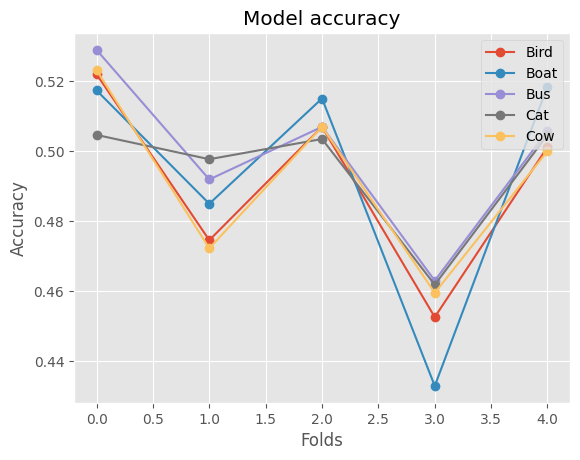

In [15]:
#just makes the plots for model
def main():
  print(accuracies)
  acc = [[],[],[],[],[]]

  #reforms the accuracies for easier looking
  for fold in accuracies:
    for clas in range(len(fold)):
       acc[clas].append(fold[clas])
  print(acc)
  
  MakePlots(accuracies)

if __name__ == "__main__":
    main()